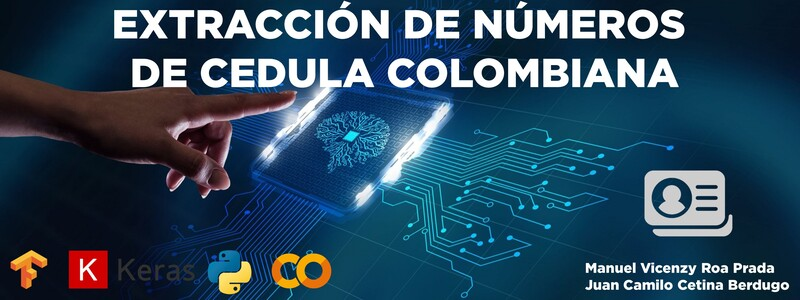

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/proyecto_IA/
!pwd

Mounted at /content/drive
/content/drive/My Drive/proyecto_IA
/content/drive/My Drive/proyecto_IA


In [ ]:
import cv2 as cv
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab.patches import cv2_imshow

img size:  (380, 728)


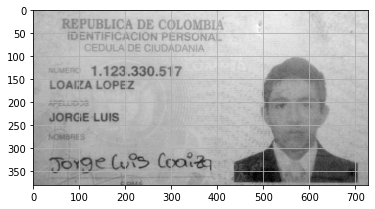

In [ ]:
id = cv.imread("/content/drive/MyDrive/proyecto_IA/img/cedula2.jpg", 1) #Se lee la imagen desde la carpeta
idGray = cv.cvtColor(id, cv.COLOR_BGR2GRAY) #Se cambian los colores a escala de grises
plt.imshow(idGray, cmap='gray'); #Mostramos la imagen
plt.grid() #Se grafica la imagen con una rejilla 
print("img size: ", idGray.shape)

(25, 202)

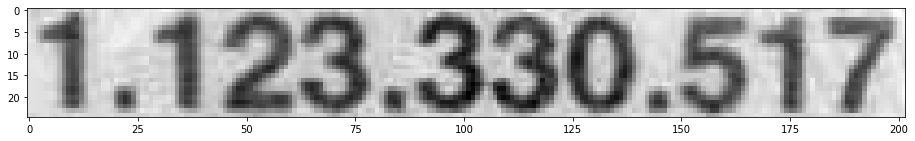

In [ ]:
crop_img = idGray[120:145, 124:326]#se realiza un recorte de la parte numerica 
plt.figure(figsize = (20,2))#se define el tamaño de la imagen 
plt.imshow(crop_img, cmap='gray')#se muestra la imagen 
crop_img.shape

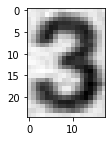

In [ ]:
crop= crop_img[0:, 88:106]
plt.figure(figsize = (20,2))
plt.imshow(crop, cmap='gray')

In [ ]:
cutIms=[]  #se crean listas las cuales alojaran los recortes de la imagen 
cutIm=[]

tamaño=51 #17 es el tamaño del numero entonce 17*3=51
cutMin=crop_img.shape[1]-(tamaño)# a la imagen con el numero de cedula , se le definen los limites de corte , para proceder a recortar nuevamente 
cutMax=crop_img.shape[1]
i=0
for i in range(3):#definimos el numero de cortes a realizar 
  crop = crop_img[0:, cutMin:cutMax] #cortamos la imagen con los parametros de corte ya establecidos 
  cutMin=cutMin-tamaño-11 #se redefine los limites de recorte para proceder con el siguiente recorte
  cutMax=cutMax-tamaño-11
  print (cutMin, cutMax)
  cutIms.append(crop)  #alojamos los recortes de las imagenes en nuestra lista 
if(cutMax<17): #para el ultimo rcorte condicinamos el recorte , ya que el ultimo numero tiene diferentes dimenciones y tiene parametros de posicionamiento exactos 
  crop = crop_img[0:, 0:cutMax+1]#se hace el recorte 
  cutIm.append(crop)# se guarda el primero numero en una lista 

89 140
27 78
-35 16


In [ ]:
cutIms=np.array(cutIms)
cedula = []                # se guardan todos los recortes en una sola lista de manera ordenada 
cedula.append(cutIm[0])
cedula.append(cutIms[2])
cedula.append(cutIms[1])
cedula.append(cutIms[0])

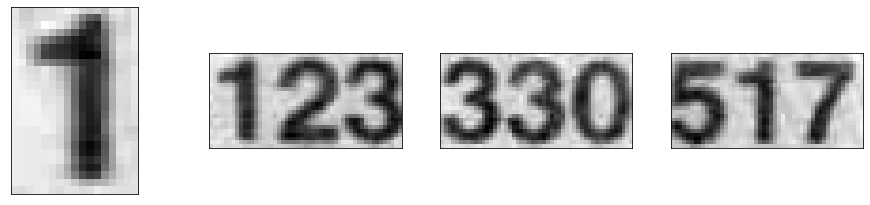

In [ ]:
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(5,5,i+1) #imprimimos nuestros recortes de cedula 
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cedula[i], cmap='gray')

In [ ]:
cedula[0].shape[1]

17

In [ ]:
numeros=[]
tamañoNum=17 #17 pixeles de ancho mide cada numero
minCorte=0
maxCorte=17
for i in range(4):
  minCorte=0  
  maxCorte=17
  if(cedula[i].shape[1]<=tamañoNum):
    numeros.append(cedula[i])
  else:
    j=0
    while(j<3):
      num = cedula[i][0:, minCorte:maxCorte]
      minCorte=minCorte+tamañoNum
      maxCorte=maxCorte+tamañoNum
      numeros.append(num)
      j=j+1

(25, 17)


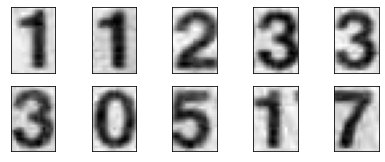

In [ ]:
plt.figure(figsize=(7,7))#imprimimos nuestros cortes de numeros con sus dimensiones 
print(numeros[0].shape)
for i in range(len(numeros)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(numeros[i], cmap='gray')

In [ ]:
#ajustamos el tamaño de las imagenes a 28x28
numerosA = np.array(numeros)

numeros28=[]


for i in range(len(numerosA)):
  ajustar = cv.resize(numerosA[i], (28,28), interpolation = cv.INTER_AREA)
  numeros28.append(ajustar)
  

(28, 28)


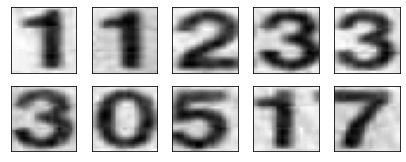

In [ ]:
plt.figure(figsize=(7,7))
print(numeros28[0].shape)
for i in range(len(numeros28)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(numeros28[i], cmap='gray')

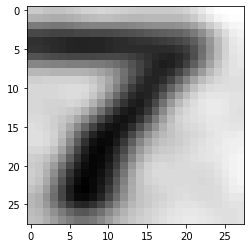

In [ ]:
numerosGaussianBlur = [] #reducimos ruidos de la imagen o la desenfocamos 
for i in range(len(numeros28)):
    desenfoque = cv.GaussianBlur(numeros28[i], (7, 5), 0)
    numerosGaussianBlur.append(desenfoque)
    plt.imshow(numerosGaussianBlur[i], cmap='gray')

(28, 28)


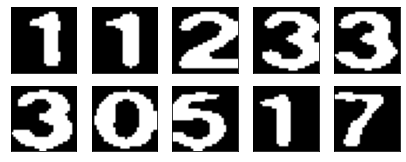

In [ ]:
numerosB = []#cambiamos el color de cada uno de los pixeles por aproximacion y de manera binaria 
for i in range(len(numerosGaussianBlur)):
    t, res = cv.threshold(numerosGaussianBlur[i], 135, 1, cv.THRESH_BINARY_INV)
    numerosB.append(res)
    
plt.figure(figsize=(7,7))
print(numerosB[0].shape)
for i in range(len(numerosB)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(numerosB[i], cmap='gray')

(28, 28)


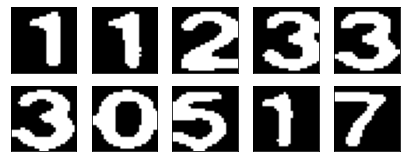

In [ ]:
numerosB = []#se detalla mas la imagen reduciendo el error 
for i in range(len(numerosGaussianBlur)):
    t, res = cv.threshold(numerosGaussianBlur[i], 140, 1, cv.THRESH_BINARY_INV)
    numerosB.append(res)
se = np.ones((1,2),np.float32)

for i in range(len(numerosB)):
  numerosB[i] = cv.morphologyEx(numerosB[i], cv.MORPH_ERODE, se)

plt.figure(figsize=(7,7))
print(numerosB[0].shape)
for i in range(len(numerosB)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(numerosB[i], cmap='gray')

# RED NEURONAL CONVOLUCIONAL (CNN)

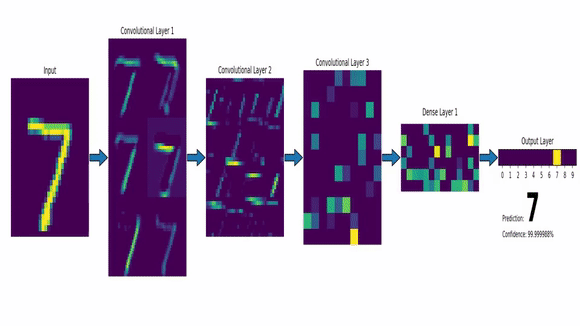

 MNIST
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


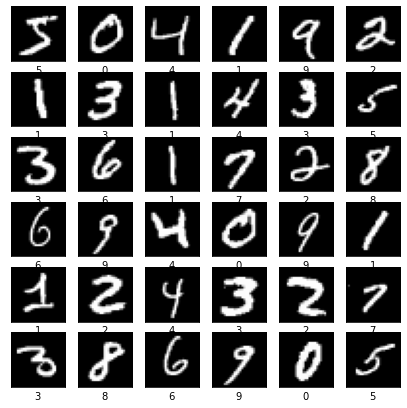

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
print( " MNIST")
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

class_names = ['0','1','2','3','4','5','6','7','8','9']
plt.figure(figsize=(7,7))
for i in range(36):
    plt.subplot(6,6,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.xlabel(class_names[y_train[i]])

x_train = x_train.reshape([-1, 28, 28, 1]) #-1 en la entrada x especifica que esta dimension debe calcularse dinamicamente en funcion del 
                                            #numero de entrada x, manteniendo constante el tamaño de todas las demas dimensiones, esto 
                                            #para tratar el tamaño como un parametro que podemos ajustar
x_test = x_test.reshape([-1, 28, 28, 1])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #se normazila por que los colores de pixeles tienen valores que van 0 a 255 con esta transformacion nos quedara un valor entre 0 y 1
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

In [ ]:
model =  keras.models.Sequential()
#32 filtros de 2x2
#Se aplica la funcion de activacion ReLu para anular valores negativos y dejar los positivos tal y como entran
#Se aplica un padding same para rellenar bordes con ceros 
model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(28, 28, 1))) 

model.add(keras.layers.MaxPooling2D((2, 2))) #reduce la imagen
model.add(keras.layers.Conv2D(50, (5, 5), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten()) #Aplana imagen
model.add(keras.layers.Dense(100, activation='relu'))
# La función de activación softmax simplifica esto para que los resultados de la red neuronal sean más fáciles de interpretar
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        40050     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2450)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [ ]:
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


938/938 [==============================] - 5s 5ms/step - loss: 0.7689 - accuracy: 0.7970 - val_loss: 0.2389 - val_accuracy: 0.9281
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1944 - accuracy: 0.9419 - val_loss: 0.1529 - val_accuracy: 0.9498
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1344 - accuracy: 0.9595 - val_loss: 0.1050 - val_accuracy: 0.9664
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1048 - accuracy: 0.9679 - val_loss: 0.0861 - val_accuracy: 0.9742
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0878 - accuracy: 0.9733 - val_loss: 0.0808 - val_accuracy: 0.9759
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0771 - accuracy: 0.9761 - val_loss: 0.0627 - val_accuracy: 0.9806
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0687 - accuracy: 0.9788 - val_loss: 0.0569 - val_accuracy: 0.9813
Epoch 8/10
938/93

# PREDICCIÓN DE LOS NUMEROS DE NUESTRA CEDULA

In [ ]:
for i in range(len(numerosB)):
  numerosB[i] =  numerosB[i].reshape([-1, 28, 28, 1])
preds=[]
for i in range(len(numerosB)):
  predictions = model.predict(numerosB[i])
  preds.append(np.argmax(predictions))
print ("Predicción:", preds ) 

Predicción: [7, 3, 2, 3, 3, 3, 0, 5, 7, 7]


In [ ]:
a = " ".join(map(str, preds))
print("Numero de cedula: ", a )
print("Numero de cedula original: 1 1 2 3 3 3 0 5 1 7")

Numero de cedula:  7 3 2 3 3 3 0 5 7 7
Numero de cedula original: 1 1 2 3 3 3 0 5 1 7


Finalmente hay una predicción de 7 numeros en la cedula original